# SportVision — Real-Time Sports Analytics

Detect players & ball, track movement, classify teams, compute possession/speed/distance/heatmaps.

**Runtime → Change runtime type → GPU (T4)** for best performance.

## 1. Install

In [2]:
!pip install -q numpy opencv-python supervision scikit-learn
!pip install -q rf-detr
!pip install rfdetr
!pip install -q "sportvision @ git+https://github.com/MohibShaikh/sportvision.git"

# Verify install
import sportvision
print("sportvision installed successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.4/217.4 kB 9.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement rf-detr (from versions: none)
ERROR: No matching distribution found for rf-detr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.7

## 2. Upload your video

Upload a sports clip, or download a sample from the web.

In [3]:
import os

# Option A: Upload from your machine
from google.colab import files
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]

# Option B: Download from YouTube
# !pip install -q yt-dlp
# !yt-dlp -f "best[ext=mp4]" -o sample.mp4 "https://youtu.be/4AwYxLFcX74"
# VIDEO_PATH = "sample.mp4"

# Option C: Direct URL (uncomment below)
# !wget -q -O sample.mp4 "YOUR_DIRECT_MP4_URL_HERE"
# VIDEO_PATH = "sample.mp4"

print(f"Using video: {VIDEO_PATH} ({os.path.getsize(VIDEO_PATH)/1024/1024:.1f} MB)")

Saving mixkit-semi-pro-soccer-game-43485-hd-ready.mp4 to mixkit-semi-pro-soccer-game-43485-hd-ready.mp4
Using video: mixkit-semi-pro-soccer-game-43485-hd-ready.mp4 (2.5 MB)


## 3. Run the pipeline

In [4]:
import cv2
import numpy as np
from sportvision.detection import SportsDetector
from sportvision.tracking import SportsTracker
from sportvision.analytics.possession import PossessionTracker
from sportvision.analytics.speed import SpeedEstimator
from sportvision.analytics.distance import DistanceCalculator
from sportvision.analytics.heatmap import HeatmapGenerator
from sportvision.annotators import (
    TeamColorAnnotator,
    StatsOverlayAnnotator,
    TrailAnnotator,
)

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Cannot open {VIDEO_PATH}"

fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video: {w}x{h} @ {fps:.1f}fps, {total} frames")

# Init modules
detector = SportsDetector(confidence_threshold=0.10)
tracker = SportsTracker()
possession = PossessionTracker()
speed_est = SpeedEstimator(fps=fps)
distance_calc = DistanceCalculator()
heatmap = HeatmapGenerator(resolution=(105, 68))
team_ann = TeamColorAnnotator(
    home_color=(0, 0, 255), away_color=(255, 0, 0)
)
stats_ann = StatsOverlayAnnotator()
trail_ann = TrailAnnotator(trail_length=20)

# Storage
positions: dict[int, list[tuple[float, float]]] = {}
frame_indices: dict[int, list[int]] = {}
trails: dict[int, list[tuple[float, float]]] = {}

OUTPUT_PATH = "output.mp4"
writer = cv2.VideoWriter(
    OUTPUT_PATH, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h)
)

MAX_FRAMES = 400  # adjust or set to total for full video
frame_num = 0
det_counts = []

while True:
    ret, frame = cap.read()
    if not ret or frame_num >= MAX_FRAMES:
        break

    dets = detector.detect(frame)
    n_dets = len(dets["xyxy"])
    det_counts.append(n_dets)

    tracked = tracker.update(dets)
    n_tracked = len(tracked["xyxy"])

    if n_tracked > 0:
        centers = (tracked["xyxy"][:, :2] + tracked["xyxy"][:, 2:]) / 2

        for i, tid in enumerate(
            tracked.get("tracker_id", range(n_tracked))
        ):
            tid = int(tid)
            cx, cy = float(centers[i][0]), float(centers[i][1])
            positions.setdefault(tid, []).append((cx, cy))
            frame_indices.setdefault(tid, []).append(frame_num)
            trails.setdefault(tid, []).append((cx, cy))

        class_ids = tracked.get(
            "class_id", np.zeros(n_tracked, dtype=int)
        )
        ball_mask = class_ids == 1
        player_mask = class_ids == 0

        # Update heatmap for all detected players (no ball required)
        if player_mask.any():
            player_pos = centers[player_mask]
            team_ids = np.zeros(len(player_pos), dtype=int)
            if len(player_pos) > 1:
                team_ids[len(player_pos) // 2 :] = 1
            field_pos = player_pos * np.array([[105 / w, 68 / h]])
            heatmap.update(field_pos, team_ids)

        # Update possession only when ball is detected
        if ball_mask.any() and player_mask.any():
            ball_pos = centers[ball_mask][0]
            player_pos = centers[player_mask]
            team_ids = np.zeros(len(player_pos), dtype=int)
            if len(player_pos) > 1:
                team_ids[len(player_pos) // 2 :] = 1
            possession.update(player_pos, team_ids, ball_pos)

    # Annotate
    annotated = frame.copy()
    if n_tracked > 0:
        team_ids_ann = tracked.get(
            "class_id", np.zeros(n_tracked, dtype=int)
        )
        annotated = team_ann.annotate(
            annotated, tracked["xyxy"], team_ids_ann
        )

    poss_stats = possession.get_stats()
    annotated = stats_ann.annotate(annotated, possession=poss_stats)
    annotated = trail_ann.annotate(annotated, trails)

    writer.write(annotated)
    frame_num += 1

    if frame_num % 50 == 0:
        print(
            f"  Frame {frame_num}/{MAX_FRAMES}: "
            f"{n_dets} detections, {n_tracked} tracked"
        )

cap.release()
writer.release()
print(f"\nProcessed {frame_num} frames.")

Video: 1280x720 @ 24.0fps, 161 frames


[2026-02-27 18:29:17] [INFO] rf-detr - Downloading pretrained weights for rf-detr-base.pth


rf-detr-base.pth:   0%|          | 0.00/355M [00:00<?, ?iB/s]

[2026-02-27 18:29:28] [INFO] rf-detr - MD5 validation successful for rf-detr-base.pth
[2026-02-27 18:29:29] [INFO] rf-detr - Loading pretrain weights


[2026-02-27 18:29:30] [WARNING] rf-detr - Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


  Frame 50/400: 1 detections, 1 tracked
  Frame 100/400: 4 detections, 4 tracked
  Frame 150/400: 4 detections, 4 tracked

Processed 161 frames.


## 4. Results

In [5]:
print(f"{'='*50}")
print("RESULTS")
print(f"{'='*50}")
print(f"Frames processed: {frame_num}")
print(f"Avg detections/frame: {np.mean(det_counts):.1f}")
print(f"Max detections/frame: {max(det_counts)}")
print(f"Min detections/frame: {min(det_counts)}")
print(f"Unique tracker IDs: {len(positions)}")

speeds = speed_est.calculate(positions, frame_indices)
if speeds:
    print(
        f"Speed range: {min(speeds.values()):.1f}"
        f" - {max(speeds.values()):.1f} km/h"
    )

distances = distance_calc.calculate(positions)
if distances:
    print(
        f"Distance range: {min(distances.values()):.1f}"
        f" - {max(distances.values()):.1f} px"
    )

print(f"Possession: {poss_stats}")
print(f"\nOutput: {OUTPUT_PATH} ({os.path.getsize(OUTPUT_PATH)/1024:.0f} KB)")

RESULTS
Frames processed: 161
Avg detections/frame: 3.2
Max detections/frame: 11
Min detections/frame: 0
Unique tracker IDs: 511
Speed range: 0.0 - 0.0 km/h
Distance range: 0.0 - 0.0 px
Possession: {0: 0.5, 1: 0.5}

Output: output.mp4 (4721 KB)


## 5. Heatmap visualization

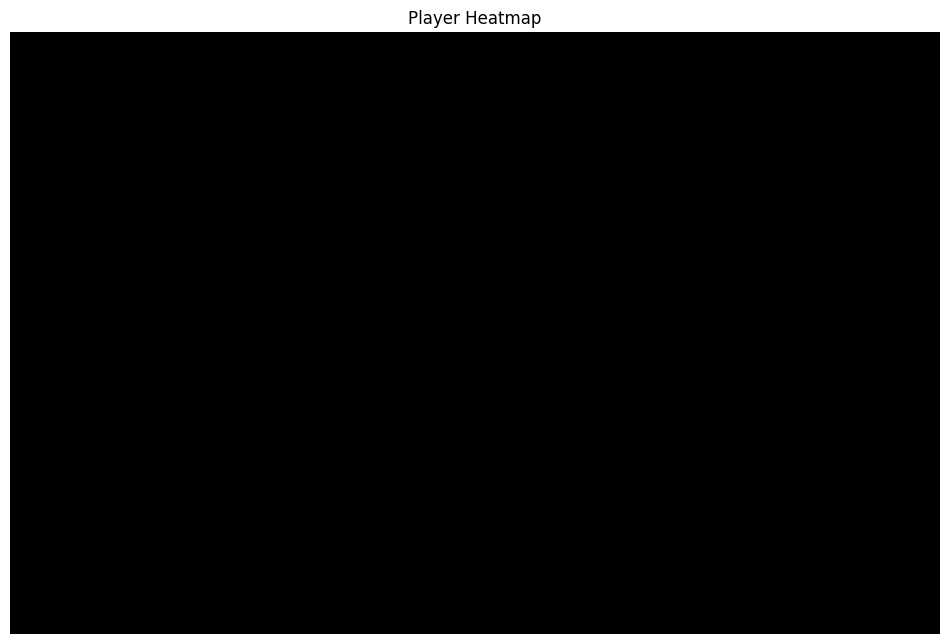

In [6]:
import matplotlib.pyplot as plt

heatmap_img = heatmap.render()
if heatmap_img is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
    plt.title("Player Heatmap")
    plt.axis("off")
    plt.show()
else:
    print("No heatmap data collected.")

## 6. Preview output & download

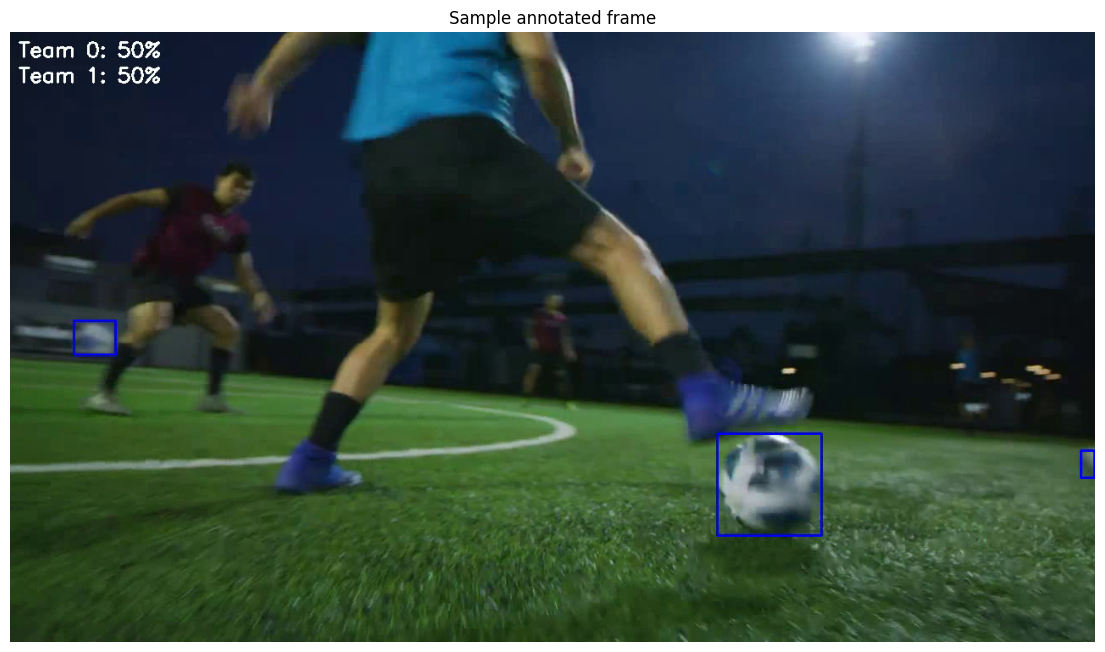

In [11]:
from IPython.display import HTML
from base64 import b64encode

# Show a sample frame
cap2 = cv2.VideoCapture(OUTPUT_PATH)
cap2.set(cv2.CAP_PROP_POS_FRAMES, min(100, frame_num - 100))
ret, sample = cap2.read()
cap2.release()
if ret:
    plt.figure(figsize=(14, 8))
    plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    plt.title("Sample annotated frame")
    plt.axis("off")
    plt.show()

# Inline video playback (works for small videos)
video_data = open(OUTPUT_PATH, "rb").read()
if len(video_data) < 50 * 1024 * 1024:  # under 50MB
    b64 = b64encode(video_data).decode()
    HTML(f"""
    <video width="720" controls>
      <source src="data:video/mp4;base64,{b64}" type="video/mp4">
    </video>""")
else:
    print("Video too large for inline playback. Download it below.")

In [12]:
# Download the output video
files.download(OUTPUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>